1 and 2 parameter bifurcation diagrams for vdp-thal

# Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp

import vdp_thal

import importlib
import lib

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps,get_es_min,get_es_max)

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)

import lib.rhs

importlib.reload(sys.modules['lib.util'])
importlib.reload(sys.modules['lib.rhs'])
from lib.util import (get_phase, freq_est)
#from lib.rhs import (_redu)
from lib.rhs import _redu_c2, _full, _full_mono_rhs

_redu = _redu_c2

from importlib import reload
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os
from matplotlib.patches import Circle

from scipy.optimize import root,bisect
from copy import deepcopy

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

# Dicts

In [2]:
kw_sim = {'rtol':1e-7,'atol':1e-7,'method':'LSODA'}

In [3]:
pd_thal = {'gL':0.05,'gna':3,'gk':5,
           'gt':5,'eL':-70,'ena':50,
           'ek':-90,'et':0,'esyn':-100,
           'c':1,'alpha':3,'beta':2,
           'sigmat':0.8,'vt':-20,'del':0,
           'ib':8.2,'om':1,'om_fix':1}

pd_vdp = {'mu':.04,'sigmat':0.1,'vt':1,
          'alpha':3,'beta':2,'esyn':-2,
          'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws_thal = {'var_names':['v','h','r','w'],
            'pardict':pd_thal,
            'rhs':vdp_thal.rhs_thal,
            'coupling':vdp_thal.coupling_thal,
            'init':np.array([-.64,0.71,0.25,0,6]),
            'TN':10000,
            'trunc_order':1,
            'z_forward':False,
            'i_forward':False,
            'i_bad_dx':[False,True,False,False,False,False],
            'max_iter':20,
            'rtol':1e-12,
            'atol':1e-12,
            'rel_tol':1e-9,
            'save_fig':True,
            'lc_prominence':.05}

kws_vdp = {'var_names':['v','h','w'],
               'pardict':pd_vdp,
               'rhs':vdp_thal.rhs_vdp,
               'coupling':vdp_thal.coupling_vdp,
               'init':np.array([.32,0.128,0.54,20]),
               'TN':10000,
               'trunc_order':1,
               'z_forward':False,
               'i_forward':False,
               'i_bad_dx':[False,True,False,False,False,False],
               'max_iter':20,
               'rtol':1e-10,
               'atol':1e-10,
               'rel_tol':1e-8,
               'save_fig':True,
               'lc_prominence':.05}

In [5]:
het_coeffs = [1,20]

# Defs

In [6]:
mname1 = 'vdp_thal12_b={}'
mname2 = 'vdp_thal12_b2={}'

mname_list = ['vdp_thal11_b'+str(i)+'={}' for i in range(5)]

In [7]:
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_vdp_thal/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':10000,
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [8]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.concatenate([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=False,
                 return_full=False,**kwargs):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = path_loc+'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = path_loc+'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]
        #dat2[:,3] = solr_o3.y[0]
        #dat2[:,4] = solr_o4.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

# Initialize

In [9]:
system1 = rsp(idx=0,model_name='vdp_thal0',**kws_thal)
system2 = rsp(idx=1,model_name='vdp_thal1',**kws_vdp)

mkdir ./data/vdp_thal0/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0084015231173136
self.T 6.283185307179586
LC0 ini[-0.10425117  0.22993228  0.09898925  0.40570217]
LC0 fin[-0.10425117  0.22993228  0.09898925  0.40570217]
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024653498269982924
* Loading g symbolic...
* Computing g...
g0 ini[0. 0. 0. 0.]
g0 fin[0. 0. 0. 0.]
g1 ini[ 0.00253413 -0.64088722 -0.22868543  0.73277563]
g1 fin[ 0.00253409 -0.64088719 -0.22868543  0.73277558]
* Loading heterogeneous terms...
* Computing z...
z0 ini[-0.87597607 -1.17574397  3.28529655 -0.        ]
z0 fin[-0.87597607 -1.17574397  3.28529652 -0.        ]
z1 ini[-1.70646067 -0.61636896  0.14424813  0.        ]
z1 fin[-1.70646067 -0.61636896  0.14424813  0.        ]
* Computing i...
i0 ini[-0.23544813  0.01818327 -4.42638639  0.        ]
i0 fin[-0.23544811  0.01818329 -4.4263864   0.        ]
i1 ini[-9.66309554e-02  7.45216330e-01 -6.49855309e-02  8.64027668e-21]

# Initialize Coupling 1:2

In [10]:
# parameters to be fixed for 1 par diagrams
nm_tup = (1,2)

In [11]:
a12 = nm.nmCoupling(system1,system2,
                    #recompute_list=['k_gwt1','p_gwt1'],
                    #recompute_list=['p_data_gwt0','p_data_gwt1','h_data_gwt0','h_data_gwt1'],
                    #recompute_list=recompute_list,
                    _n=('om0',nm_tup[0]),_m=('om1',nm_tup[1]),
                    het_coeffs=het_coeffs,
                    NH=1024)

Initializing 12 Coupling...
pfactor 29
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H vdp_thal0, order=0...
* Loading H vdp_thal1, order=0...
* Loading H vdp_thal0, order=1...
* Loading H vdp_thal1, order=1...


In [12]:
# define aliases as a template
a = a12

nm_val = str(nm_tup[0])+str(nm_tup[1])

In [13]:
etup = (.001,.2,100)
dtup = (-.4,.2)

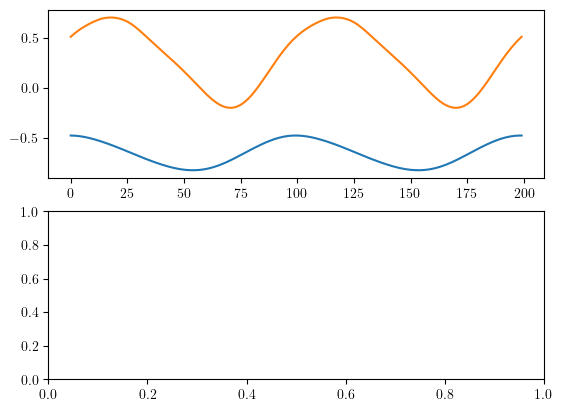

In [14]:
fig,axs = plt.subplots(2,1)
x_temp2 = np.linspace(0,2*np.pi,200)
rhs2 = a12.system1.h['lam_hom'][0](x_temp2)#_redu(0,x_temp2,a21,.1,-.0685)

rhs3 = a12.system1.h['lam_hom'][1](x_temp2)#_redu(0,x_temp2,a21,.1,-.0685)

axs[0].plot(rhs2)
axs[0].plot(rhs3)

## Plot 1par eps

In [15]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.085,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

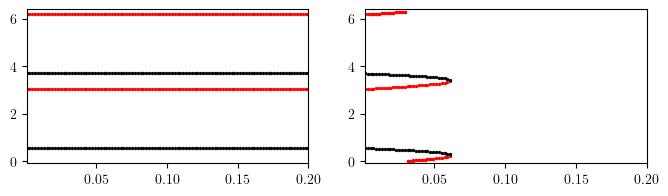

In [16]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.087,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

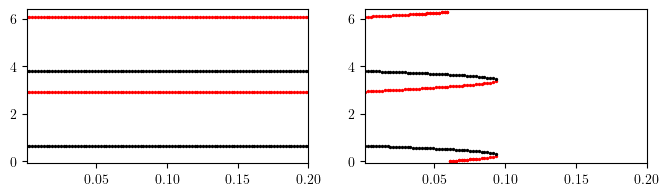

In [17]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.09,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [18]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.1,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [19]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.13,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [20]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.135,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [21]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.14,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [22]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.145,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

## Plot 1par del

In [23]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,eps=.1,del_tup=dtup,rhs=_redu_c2)
# add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)
# axs[0].set_xlabel('del'); axs[1].set_xlabel('del')

In [24]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,eps=e2,del_tup=dtup,rhs=_redu_c2)
# add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

## EPS VARY

In [25]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_vdp_thal/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_gwt_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_gwt_'+nm_val+'_b={}_u.txt'

In [26]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=-.086

#### Branches eps stable

In [27]:
b=-.086
kw_b['recompute'] = False
kw_b['b'] = b

In [28]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=4,eps_init=0.05,eps_final=0.001,deps=-.002),
            dict(phi0=4,eps_init=0.049,eps_final=0.2,deps=.002)]

In [29]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 4
phi init 4


In [30]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [31]:
kw_b['recompute'] = False
kw_b['b'] = b

In [32]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=2.5,eps_init=0.05,eps_final=0.045,deps=-.01),return_point=True,**kw_b)

phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.086_ei=0.05_ef=0.045_de=-0.01.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.086_ei=0.05_ef=0.045_de=-0.01.txt


In [33]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2.5,eps_init=0.05,eps_final=0.001,deps=-.002),
           dict(phi0=2.5,eps_init=0.05,eps_final=0.2,deps=.002)]

In [34]:
data_bu_list = []
Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.086_ei=0.05_ef=0.001_de=-0.002.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.086_ei=0.05_ef=0.001_de=-0.002.txt
phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.086_ei=0.05_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.086_ei=0.05_ef=0.2_de=0.002.txt


In [35]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

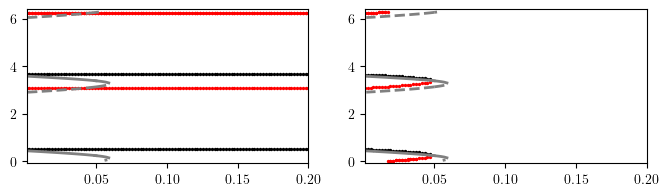

In [36]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [37]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.05890000000000001 0.13872331521203307
phi init 0.13872331521203307
Y [-0.10886125  0.23474521  0.09269426  0.400779    1.78216272 -0.58235948  0.57904365  6.27775224]
mkdir ./data/vdp_thal11_b0=-0.086/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9991352751292896
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0011487863353137058
es_min,phi0 0.05840000000000001 0.13872331521203307
phi init 0.13872331521203307
Y [-0.1086762   0.23753273  0.09281499  0.39763061  1.7671043  -0.62912307  0.57613649  6.27806479]
mkdir ./data/vdp_thal11_b1=-0.086/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9991850271398052
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0014734184922510344
es_min,phi0 0.05790000000000001 0.13872331521203307
phi init 0.13872331521203307
Y [-0.1085252   0.23868365  0.09291892  0.39635084  1.75585799 -0.66224312  0.57384239  6.27832

In [38]:
b_vals_full.append(b)

es = 0
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.087

#### Branches eps stable

In [39]:
b=-.087
kw_b['recompute'] = False
kw_b['b'] = b

In [40]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=4,eps_init=0.05,eps_final=0.001,deps=-.002),
            dict(phi0=4,eps_init=0.049,eps_final=0.2,deps=.002)]

In [41]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 4
phi init 4


In [42]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [43]:
kw_b['recompute'] = False
kw_b['b'] = b

In [44]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=2.6,eps_init=0.05,eps_final=0.045,deps=-.01),return_point=True,**kw_b)

phi init 2.6
phase_diffs_u_init=2.6_nm=12_b=-0.087_ei=0.05_ef=0.045_de=-0.01.txt
phase_diffs_u_pt_init=2.6_nm=12_b=-0.087_ei=0.05_ef=0.045_de=-0.01.txt


In [45]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2.5,eps_init=0.05,eps_final=0.001,deps=-.002),
           dict(phi0=2.5,eps_init=0.05,eps_final=0.2,deps=.002)]

In [46]:
data_bu_list = []
Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.087_ei=0.05_ef=0.001_de=-0.002.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.087_ei=0.05_ef=0.001_de=-0.002.txt
phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.087_ei=0.05_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.087_ei=0.05_ef=0.2_de=0.002.txt


In [47]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

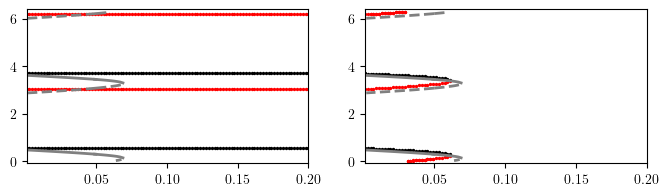

In [48]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [49]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.06890000000000002 0.137139368322015
phi init 0.137139368322015
Y [-0.10962338  0.24070313  0.09173083  0.39400176  1.75164617 -0.59801838  0.57661837  6.27679234]
mkdir ./data/vdp_thal11_b0=-0.087/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9989825128915443
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0010182299636408328
es_min,phi0 0.06840000000000002 0.137139368322015
phi init 0.137139368322015
Y [-0.1093518   0.24015882  0.09186362  0.39473404  1.73778385 -0.63760149  0.57383504  6.27721525]
mkdir ./data/vdp_thal11_b1=-0.087/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9990498179005394
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0014831631827525239
es_min,phi0 0.06790000000000002 0.137139368322015
phi init 0.137139368322015
Y [-0.1091171   0.2345444   0.09195743  0.40128708  1.73440236 -0.64656536  0.57319059  6.2775416 ]
mkdir .

In [50]:
b_vals_full.append(b)

es = 0
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.09

#### Branches eps stable

In [51]:
b=-.09
kw_b['recompute'] = False
kw_b['b'] = b

In [52]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=4,eps_init=0.05,eps_final=0.001,deps=-.002),
            dict(phi0=4,eps_init=0.049,eps_final=0.2,deps=.002)]

In [53]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 4
phi init 4


In [54]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [55]:
kw_b['recompute'] = False
kw_b['b'] = b

In [56]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=2.5,eps_init=0.05,eps_final=0.045,deps=-.01),return_point=True,**kw_b)

phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.09_ei=0.05_ef=0.045_de=-0.01.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.09_ei=0.05_ef=0.045_de=-0.01.txt


In [57]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2.5,eps_init=0.05,eps_final=0.001,deps=-.002),
           dict(phi0=2.5,eps_init=0.05,eps_final=0.102,deps=.002)]

In [58]:
data_bu_list = []
Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.09_ei=0.05_ef=0.001_de=-0.002.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.09_ei=0.05_ef=0.001_de=-0.002.txt
phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.09_ei=0.05_ef=0.102_de=0.002.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.09_ei=0.05_ef=0.102_de=0.002.txt


In [59]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

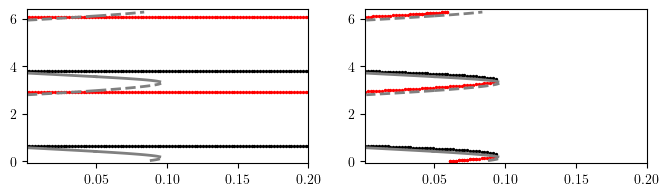

In [60]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [61]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0002*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.09600000000000004 3.2719038935808764
phi init 3.2719038935808764
Y [-0.11070769  0.23449371  0.08944423  0.40181271  1.6571791  -0.63623819  0.56751355  6.27527633]
mkdir ./data/vdp_thal11_b0=-0.09/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9987412238355807
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0013599957602978096
es_min,phi0 0.09580000000000004 3.2719038935808764
phi init 3.2719038935808764
Y [-0.11051441  0.24077872  0.0895407   0.39459002  1.64220665 -0.67587593  0.56340142  6.27551802]
mkdir ./data/vdp_thal11_b1=-0.09/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9987796931936684
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0016365538110688727
es_min,phi0 0.09560000000000005 3.2719038935808764
phi init 3.2719038935808764
Y [-0.11038151  0.23652664  0.08959126  0.3995432   1.642499   -0.67373008  0.56363584  6.27572637]
mkd

In [62]:
b_vals_full.append(b)

es = 0
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.1

#### Branches eps stable

In [63]:
b=-.1
kw_b['recompute'] = False
kw_b['b'] = b

In [64]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=4,eps_init=0.05,eps_final=0.001,deps=-.002),
            dict(phi0=4,eps_init=0.049,eps_final=0.102,deps=.002)]

In [65]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 4
phi init 4


In [66]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [67]:
kw_b['recompute'] = False
kw_b['b'] = b

In [68]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=2.5,eps_init=0.05,eps_final=0.045,deps=-1),return_point=True,**kw_b)

phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.1_ei=0.05_ef=0.045_de=-1.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.1_ei=0.05_ef=0.045_de=-1.txt


In [69]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2.5,eps_init=0.05,eps_final=0.001,deps=-.002),
           dict(phi0=2.5,eps_init=0.05,eps_final=0.2,deps=.002)]

In [70]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.1_ei=0.05_ef=0.001_de=-0.002.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.1_ei=0.05_ef=0.001_de=-0.002.txt
phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.1_ei=0.05_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.1_ei=0.05_ef=0.2_de=0.002.txt


In [71]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

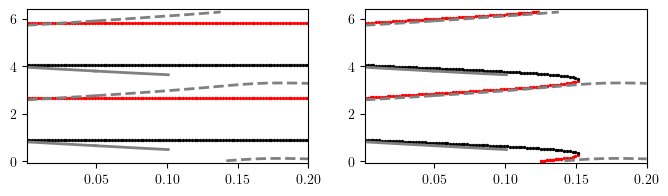

In [72]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [73]:
b_vals_full.append(b)

es = 0
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.13

#### Branches eps stable

In [74]:
b=-.13
kw_b['recompute'] = False
kw_b['b'] = b

In [75]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.2,eps_final=0.001,deps=-.01)]

In [76]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0


In [77]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [78]:
kw_b['recompute'] = False
kw_b['b'] = b

In [79]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=2.5,eps_init=0.1,eps_final=0.19,deps=-.01),return_point=True,**kw_b)

phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.13_ei=0.1_ef=0.19_de=-0.01.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.13_ei=0.1_ef=0.19_de=-0.01.txt


/Users/youngmp/Library/CloudStorage/Dropbox-Personal/projects/nm_phase_locking/code_and_data/v2_jupyter/../lib/util.py:1385: UserWarning: loadtxt: input contained no data: "/Users/youngmp/Library/CloudStorage/Dropbox-Personal/projects/nm_phase_locking/code_and_data/v2_jupyter/bif1d_vdp_thal/phase_diffs_u_init=2.5_nm=12_b=-0.13_ei=0.1_ef=0.19_de=-0.01.txt"
  data1 = np.loadtxt(fname1)


In [80]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2.6,eps_init=0.1,eps_final=0.05,deps=-.002),
           dict(phi0=2.4,eps_init=0.06,eps_final=0.0,deps=-.002)]

In [81]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2.6
phase_diffs_u_init=2.6_nm=12_b=-0.13_ei=0.1_ef=0.05_de=-0.002.txt
phase_diffs_u_pt_init=2.6_nm=12_b=-0.13_ei=0.1_ef=0.05_de=-0.002.txt
phi init 2.4
phase_diffs_u_init=2.4_nm=12_b=-0.13_ei=0.06_ef=0.0_de=-0.002.txt
phase_diffs_u_pt_init=2.4_nm=12_b=-0.13_ei=0.06_ef=0.0_de=-0.002.txt


In [82]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

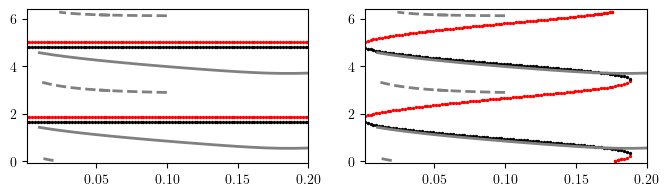

In [83]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [84]:
b_vals_full.append(b)

es = 0
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.135

In [85]:
data_bs_list = [];data_bu_list = []

#### Branches eps stable

In [86]:
b=-.135
kw_b['recompute'] = False
kw_b['b'] = b

In [87]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.2,eps_final=0.001,deps=-.01)]

In [88]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0


In [89]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [90]:
kw_b['recompute'] = False
kw_b['b'] = b

In [91]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=2.5,eps_init=0.1,eps_final=0.,deps=-1),return_point=True,**kw_b)

phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.135_ei=0.1_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.135_ei=0.1_ef=0.0_de=-1.txt


In [92]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=2.5,eps_init=0.1,eps_final=0.001,deps=-.002),
    dict(phi0=2.6,eps_init=0.099,eps_final=0.202,deps=.002)
]

In [93]:
data_bu_list = []
Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.135_ei=0.1_ef=0.001_de=-0.002.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.135_ei=0.1_ef=0.001_de=-0.002.txt
phi init 2.6
phase_diffs_u_init=2.6_nm=12_b=-0.135_ei=0.099_ef=0.202_de=0.002.txt
phase_diffs_u_pt_init=2.6_nm=12_b=-0.135_ei=0.099_ef=0.202_de=0.002.txt


In [94]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

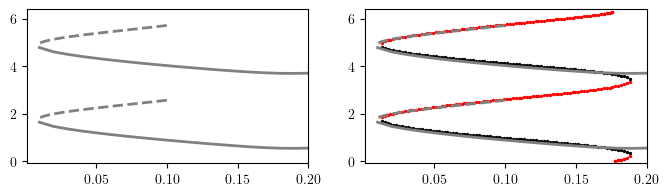

In [95]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [96]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.010099999999999842 1.6376397874055062
phi init 1.6376397874055062
Y [-0.10428439  0.2278588   0.09894039  0.40775216 -1.98382098  0.26966693  0.01248803  6.28380755]
mkdir ./data/vdp_thal11_b0=-0.135/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000990326987225
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0006861184993335661
es_min,phi0 0.010599999999999842 1.6376397874055062
phi init 1.6376397874055062
Y [-0.10427073  0.23130463  0.0989673   0.40382157 -1.98864644  0.22535057  0.01194236  6.2838598 ]
mkdir ./data/vdp_thal11_b1=-0.135/
* Loading LC data...
self.T 6.283185307179586 omfix 1.000107347593259
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0008311243420644236
es_min,phi0 0.011099999999999843 1.6376397874055062
phi init 1.6376397874055062
Y [-0.10429138  0.23373814  0.09898935  0.40103221 -1.99229509  0.1832118   0.01144661  6.28391173]

In [97]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.14

#### Branches eps stable

In [98]:
b=-.14
kw_b['recompute'] = False
kw_b['b'] = b

In [99]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.2,eps_final=0.001,deps=-.01)]

In [100]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0


In [101]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [102]:
kw_b['recompute'] = False
kw_b['b'] = b

In [103]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=2.5,eps_init=0.1,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.14_ei=0.1_ef=0_de=-1.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.14_ei=0.1_ef=0_de=-1.txt


In [104]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=2.5,eps_init=0.1,eps_final=0.0,deps=-.005),
    dict(phi0=2.5,eps_init=0.099,eps_final=0.21,deps=.005)
]

In [105]:
data_bu_list = []
Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.14_ei=0.1_ef=0.0_de=-0.005.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.14_ei=0.1_ef=0.0_de=-0.005.txt
phi init 2.5
phase_diffs_u_init=2.5_nm=12_b=-0.14_ei=0.099_ef=0.21_de=0.005.txt
phase_diffs_u_pt_init=2.5_nm=12_b=-0.14_ei=0.099_ef=0.21_de=0.005.txt


In [106]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

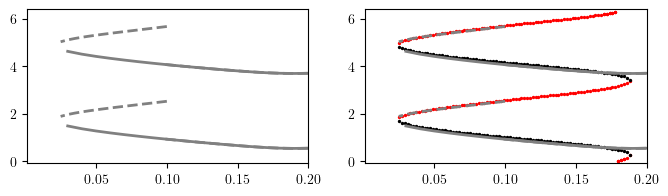

In [107]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [108]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.02509999999999994 1.8819559810906075
phi init 1.8819559810906075
Y [-0.10416481  0.22863782  0.09905858  0.40654353 -1.99562153 -0.01459288  0.00937663  6.28498594]
mkdir ./data/vdp_thal11_b0=-0.14/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0002865791821143
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.002902339991169748
es_min,phi0 0.02559999999999994 1.8819559810906075
phi init 1.8819559810906075
Y [-0.10417959  0.23324798  0.0991009   0.40127748 -1.99494967 -0.03341843  0.00920034  6.28505934]
mkdir ./data/vdp_thal11_b1=-0.14/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0002982611113542
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.003126358866291705
es_min,phi0 0.02609999999999994 1.8819559810906075
phi init 1.8819559810906075
Y [-0.10414457  0.22590001  0.09909359  0.40967185 -1.99129956 -0.10556984  0.00855685  6.28513274]
mkdir

In [109]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.145

#### Sim

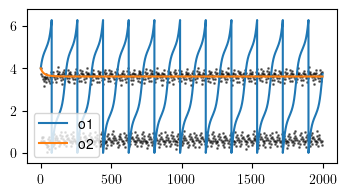

In [110]:
a=a12;T=2000;b=-.145;e=.18;phi0 = 4
dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
t1=dat1[:,0];y=dat1[:,1]
t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

fig,axs = plt.subplots(figsize=(4,2))

axs.scatter(t1,y,s=1,alpha=.5,color='black')

axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

axs.set_ylim(-.5,2*np.pi+.5)
axs.legend()

#### Branches eps stable

In [111]:
b=-.145
kw_b['recompute'] = False
kw_b['b'] = b

In [112]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.2,eps_final=0.001,deps=-.01)]

In [113]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0


In [114]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [115]:
kw_b['recompute'] = False
kw_b['b'] = b

In [116]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=6,eps_init=0.1,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 6
phase_diffs_u_init=6_nm=12_b=-0.145_ei=0.1_ef=0_de=-1.txt
phase_diffs_u_pt_init=6_nm=12_b=-0.145_ei=0.1_ef=0_de=-1.txt


In [117]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.1,eps_final=0.001,deps=-.002),
            dict(phi0=5.5,eps_init=0.095,eps_final=0.2,deps=.002)]

In [118]:
data_bu_list = []
Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    Y =Yinit # reset initial condition
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=12_b=-0.145_ei=0.1_ef=0.001_de=-0.002.txt
phase_diffs_u_pt_init=5.5_nm=12_b=-0.145_ei=0.1_ef=0.001_de=-0.002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=12_b=-0.145_ei=0.095_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=5.5_nm=12_b=-0.145_ei=0.095_ef=0.2_de=0.002.txt


In [119]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

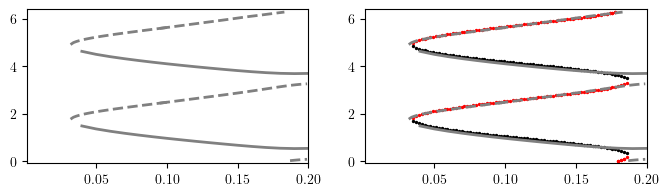

In [120]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [121]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.03209999999999995 1.7646026902542618
phi init 1.7646026902542618
Y [-0.10447642  0.2260745   0.0987652   0.40900825 -1.95806141  0.41491631  0.0144584   6.28500606]
mkdir ./data/vdp_thal11_b0=-0.145/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999896375844936
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00012089023395895898
es_min,phi0 0.03259999999999995 1.7646026902542618
phi init 1.7646026902542618
Y [-0.10439738  0.22611339  0.0988431   0.40901575 -1.97602201  0.30783274  0.01296502  6.28515024]
mkdir ./data/vdp_thal11_b1=-0.145/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000050147704207
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00024580071937959757
es_min,phi0 0.03309999999999995 1.7646026902542618
phi init 1.7646026902542618
Y [-0.1043244   0.23013157  0.09891744  0.40446421 -1.98341333  0.24719849  0.01219295  6.28526867]

In [122]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.2

#### Sim

In [123]:
# a=a12;T=1000;b=-.2;e=.19;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

#### Branches eps stable

In [124]:
b=-.2
kw_b['recompute'] = False
kw_b['b'] = b

In [125]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=0,eps_init=0.125,eps_final=0.0,deps=-.002),
    dict(phi0=0,eps_init=0.124,eps_final=0.2,deps=.002),
]

In [126]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [127]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [128]:
kw_b['recompute'] = False
kw_b['b'] = b

In [129]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.125,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=12_b=-0.2_ei=0.125_ef=0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=12_b=-0.2_ei=0.125_ef=0_de=-1.txt


In [130]:
# get an initial condition for an unstable branch
dat,Yinit2 = follow_phase_diffs_u(**dict(phi0=6,eps_init=0.139,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 6
phase_diffs_u_init=6_nm=12_b=-0.2_ei=0.139_ef=0_de=-1.txt
phase_diffs_u_pt_init=6_nm=12_b=-0.2_ei=0.139_ef=0_de=-1.txt


In [131]:
# get an initial condition for an unstable branch
dat,Yinit3 = follow_phase_diffs_u(**dict(phi0=6,eps_init=0.144,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 6
phase_diffs_u_init=6_nm=12_b=-0.2_ei=0.144_ef=0_de=-1.txt
phase_diffs_u_pt_init=6_nm=12_b=-0.2_ei=0.144_ef=0_de=-1.txt


In [132]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=5.5,eps_init=0.125,eps_final=0.0,deps=-.002),
    dict(phi0=5.5,eps_init=0.124,eps_final=0.14,deps=.002),
]

In [133]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=12_b=-0.2_ei=0.125_ef=0.0_de=-0.002.txt
phase_diffs_u_pt_init=5.5_nm=12_b=-0.2_ei=0.125_ef=0.0_de=-0.002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=12_b=-0.2_ei=0.124_ef=0.14_de=0.002.txt
phase_diffs_u_pt_init=5.5_nm=12_b=-0.2_ei=0.124_ef=0.14_de=0.002.txt


In [134]:
in_dicts = [
    dict(phi0=0,eps_init=0.143,eps_final=0.162,deps=.002),
]

In [135]:
Y=Yinit3
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat,Y = follow_phase_diffs_u(return_point=True,use_point=Y,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0
phase_diffs_u_init=0_nm=12_b=-0.2_ei=0.143_ef=0.162_de=0.002.txt
phase_diffs_u_pt_init=0_nm=12_b=-0.2_ei=0.143_ef=0.162_de=0.002.txt


In [136]:
# get an initial condition for an unstable branch
dat,Yinit4 = follow_phase_diffs_u(**dict(phi0=0,eps_init=0.16,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 0
phase_diffs_u_init=0_nm=12_b=-0.2_ei=0.16_ef=0_de=-1.txt
phase_diffs_u_pt_init=0_nm=12_b=-0.2_ei=0.16_ef=0_de=-1.txt


In [137]:
in_dicts = [
    dict(phi0=0,eps_init=0.16,eps_final=0.2,deps=.002),
]

In [138]:
Y=Yinit4
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat,Y = follow_phase_diffs_u(return_point=True,use_point=Y,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 0
phase_diffs_u_init=0_nm=12_b=-0.2_ei=0.16_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=0_nm=12_b=-0.2_ei=0.16_ef=0.2_de=0.002.txt


In [139]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

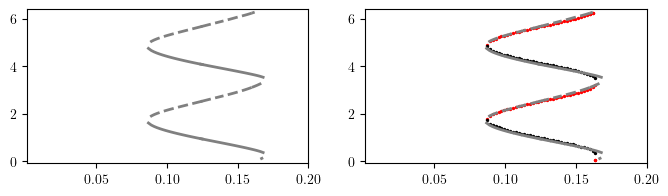

In [140]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [141]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.16790000000000005 0.36039266745704257
phi init 0.36039266745704257
Y [-0.10154921  0.23624307  0.0903223   0.40067152  1.05086635 -1.04913331  0.19429183  6.28715393]
mkdir ./data/vdp_thal11_b0=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0006316211038786
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.01922136579755201+0j)
es_min,phi0 0.16740000000000005 0.36039266745704257
phi init 0.36039266745704257
Y [-0.10119785  0.23472896  0.09070827  0.40242597  1.03370286 -1.07218637  0.17475841  6.28822351]
mkdir ./data/vdp_thal11_b1=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0008018498325497
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.02100051926631282+0j)
es_min,phi0 0.16690000000000005 0.36039266745704257
phi init 0.36039266745704257
Y [-0.10093219  0.23690127  0.09107395  0.40001187  1.00977783 -1.10159166  0.14922466  6.289

#### Monodromys min

In [142]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.08709999999999997 1.6047149372542293
phi init 1.6047149372542293
Y [-0.10428581  0.22846648  0.09921572  0.40485529 -1.98529476  0.12804636  0.01077488  6.28905427]
mkdir ./data/vdp_thal11_b0=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0006316211038786
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.01922136579755201+0j)
es_min,phi0 0.08759999999999997 1.6047149372542293
phi init 1.6047149372542293
Y [-0.10408723  0.22773206  0.09940367  0.40586757 -1.98685905  0.02068813  0.00966559  6.28941855]
mkdir ./data/vdp_thal11_b1=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0008018498325497
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.02100051926631282+0j)
es_min,phi0 0.08809999999999997 1.6047149372542293
phi init 1.6047149372542293
Y [-0.10396209  0.23139661  0.09957957  0.40179184 -1.98447588 -0.05000823  0.00899646  6.28974343]

In [143]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.25

#### Branches eps stable

In [144]:
b=-.25
kw_b['recompute'] = False
kw_b['b'] = b

In [145]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=0,eps_init=0.11,eps_final=0.0,deps=-.002),
    dict(phi0=0,eps_init=0.109,eps_final=0.2,deps=.002),
]

In [146]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [147]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [148]:
kw_b['recompute'] = False
kw_b['b'] = b

In [149]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.11,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=12_b=-0.25_ei=0.11_ef=0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=12_b=-0.25_ei=0.11_ef=0_de=-1.txt


In [150]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=5.5,eps_init=0.11,eps_final=0.0,deps=-.002),
    dict(phi0=5.8,eps_init=0.109,eps_final=0.15,deps=.002),
]

In [151]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=12_b=-0.25_ei=0.11_ef=0.0_de=-0.002.txt
phase_diffs_u_pt_init=5.5_nm=12_b=-0.25_ei=0.11_ef=0.0_de=-0.002.txt
phi init 5.8
phase_diffs_u_init=5.8_nm=12_b=-0.25_ei=0.109_ef=0.15_de=0.002.txt
phase_diffs_u_pt_init=5.8_nm=12_b=-0.25_ei=0.109_ef=0.15_de=0.002.txt


In [152]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

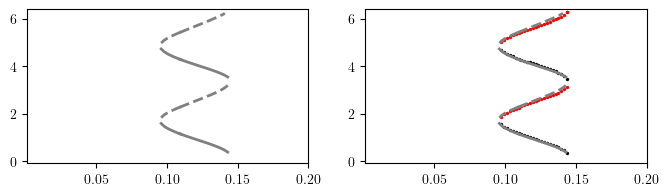

In [153]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [154]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.14290000000000003 0.37735888344430446
phi init 0.37735888344430446
Y [-0.10196735  0.23854335  0.09122471  0.39790734  1.10096694 -1.16903193  0.22872318  6.28752372]
mkdir ./data/vdp_thal11_b0=-0.25/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0006904770108147
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.01658929867705892+0j)
es_min,phi0 0.14240000000000003 0.37735888344430446
phi init 0.37735888344430446
Y [-0.10134772  0.23087302  0.09183254  0.40663011  1.07490357 -1.19949351  0.20000835  6.2890896 ]
mkdir ./data/vdp_thal11_b1=-0.25/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0009396949144547
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.018125384296483527+0j)
es_min,phi0 0.14190000000000003 0.37735888344430446
phi init 0.37735888344430446
Y [-0.10086669  0.23063283  0.09241082  0.40695055  1.03339646 -1.24318258  0.15688214  6.

#### Monodromys min

In [155]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.09609999999999999 1.5821343905229126
phi init 1.5821343905229126
Y [-0.10410055  0.22544101  0.09945944  0.40824704 -1.98568458  0.01600287  0.00961394  6.29001243]
mkdir ./data/vdp_thal11_b0=-0.25/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0006904770108147
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.01658929867705892+0j)
es_min,phi0 0.09659999999999999 1.5821343905229126
phi init 1.5821343905229126
Y [-0.10383331  0.229465    0.09974197  0.4038716  -1.98020433 -0.0997683   0.00854688  6.2905398 ]
mkdir ./data/vdp_thal11_b1=-0.25/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0009396949144547
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.018125384296483527+0j)
es_min,phi0 0.09709999999999999 1.5821343905229126
phi init 1.5821343905229126
Y [-0.10359862  0.22818462  0.09995616  0.40554907 -1.96789023 -0.2176665   0.00757792  6.291008

In [156]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.3

#### Branches eps stable

In [157]:
b=-.3
kw_b['recompute'] = False
kw_b['b'] = b

In [158]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=0,eps_init=0.11,eps_final=0.0,deps=-.002),
    dict(phi0=0,eps_init=0.109,eps_final=0.2,deps=.002),
]

In [159]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [160]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [161]:
kw_b['recompute'] = False
kw_b['b'] = b

In [162]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.11,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=12_b=-0.3_ei=0.11_ef=0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=12_b=-0.3_ei=0.11_ef=0_de=-1.txt


In [163]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=5.5,eps_init=0.11,eps_final=0.0,deps=-.002),
    dict(phi0=5.8,eps_init=0.109,eps_final=0.15,deps=.002),
]

In [164]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=12_b=-0.3_ei=0.11_ef=0.0_de=-0.002.txt
phase_diffs_u_pt_init=5.5_nm=12_b=-0.3_ei=0.11_ef=0.0_de=-0.002.txt
phi init 5.8
phase_diffs_u_init=5.8_nm=12_b=-0.3_ei=0.109_ef=0.15_de=0.002.txt
phase_diffs_u_pt_init=5.8_nm=12_b=-0.3_ei=0.109_ef=0.15_de=0.002.txt


In [165]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

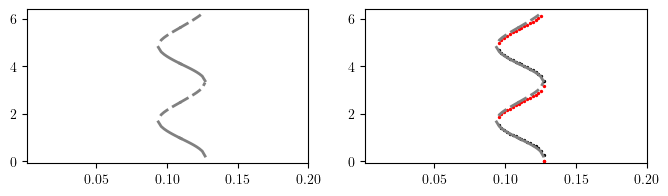

In [166]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [167]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.1269 0.2120492444087798
phi init 0.2120492444087798
Y [-0.10850993  0.24272782  0.08838565  0.39307271  1.42652636 -0.86411806  0.50140797  6.27753828]
mkdir ./data/vdp_thal11_b0=-0.3/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9991012371111494
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004763318711004449
es_min,phi0 0.1264 0.2120492444087798
phi init 0.2120492444087798
Y [-0.10523482  0.24143016  0.08997654  0.39441304  1.29367024 -1.04866528  0.41016497  6.2822438 ]
mkdir ./data/vdp_thal11_b1=-0.3/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9998501494715458
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.009967466967732047
es_min,phi0 0.1259 0.2120492444087798
phi init 0.2120492444087798
Y [-0.1033794   0.23818879  0.09108892  0.39808962  1.20605341 -1.15298533  0.32839533  6.28522422]
mkdir ./data/vdp_thal11_b2=-0.3/
* Loading LC 

#### Monodromys min

In [168]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.09409999999999999 1.651124545007792
phi init 1.651124545007792
Y [-0.10456799  0.22478023  0.09900521  0.40864745 -1.97718806  0.23504506  0.01200549  6.28912157]
mkdir ./data/vdp_thal11_b0=-0.3/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9991012371111494
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004763318711004449
es_min,phi0 0.09459999999999999 1.651124545007792
phi init 1.651124545007792
Y [-1.04045361e-01  2.30708670e-01  9.95428445e-02  4.02306320e-01 -1.98534647e+00  1.20099879e-03  9.47058185e-03  6.29004218e+00]
mkdir ./data/vdp_thal11_b1=-0.3/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9998501494715458
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.009967466967732047
es_min,phi0 0.09509999999999999 1.651124545007792
phi init 1.651124545007792
Y [-0.10366905  0.22821712  0.0998714   0.4054998  -1.97212946 -0.18683496  0.007

In [169]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.4

#### Branches eps stable

In [170]:
b=-.4
kw_b['recompute'] = False
kw_b['b'] = b

In [171]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=0,eps_init=0.09,eps_final=0.0,deps=-.001),
    dict(phi0=0,eps_init=0.089,eps_final=0.2,deps=.001),
]

In [172]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [173]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [174]:
kw_b['recompute'] = False
kw_b['b'] = b

In [175]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.09,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=12_b=-0.4_ei=0.09_ef=0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=12_b=-0.4_ei=0.09_ef=0_de=-1.txt


In [176]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=5.5,eps_init=0.09,eps_final=0.0,deps=-.001),
    dict(phi0=5.8,eps_init=0.089,eps_final=0.15,deps=.001),
]

In [177]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=12_b=-0.4_ei=0.09_ef=0.0_de=-0.001.txt
phase_diffs_u_pt_init=5.5_nm=12_b=-0.4_ei=0.09_ef=0.0_de=-0.001.txt
phi init 5.8
phase_diffs_u_init=5.8_nm=12_b=-0.4_ei=0.089_ef=0.15_de=0.001.txt
phase_diffs_u_pt_init=5.8_nm=12_b=-0.4_ei=0.089_ef=0.15_de=0.001.txt


In [178]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

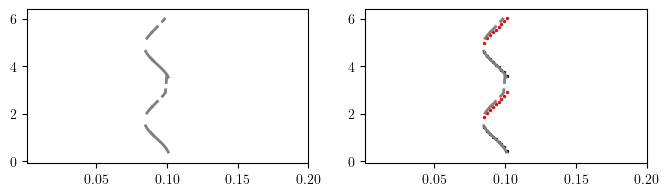

In [179]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [180]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)

eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0851 1.4846951927686183
phi init 1.4846951927686183
Y [-0.10340365  0.22634383  0.10004125  0.40819406 -1.94091755 -0.38307517  0.00639967  6.29057745]
mkdir ./data/vdp_thal11_b0=-0.4/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0011764959365226
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0148062975515108
es_min,phi0 0.0856 1.4846951927686183
phi init 1.4846951927686183
Y [-1.03065934e-01  2.27256065e-01  1.00365537e-01  4.07482338e-01 -1.88711376e+00 -5.78941331e-01  5.20379521e-03  6.29138746e+00]
mkdir ./data/vdp_thal11_b1=-0.4/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0013054138086612
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.01751878408410053
es_min,phi0 0.0861 1.4846951927686183
phi init 1.4846951927686183
Y [-1.02792981e-01  2.26178691e-01  1.00618647e-01  4.08987040e-01 -1.82130561e+00 -7.51288879e-01  4.30942259e-03  6

#### Monodromys max

In [181]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.1009 0.3798419320895041
phi init 0.3798419320895041
Y [-0.10293698  0.23556624  0.09287831  0.4007783   1.19712075 -1.28223586  0.30179995  6.28637336]
mkdir ./data/vdp_thal11_b0=-0.4/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0011764959365226
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0148062975515108
es_min,phi0 0.1004 0.3798419320895041
phi init 0.3798419320895041
Y [-0.10165046  0.23151516  0.09408645  0.40543501  1.06321222 -1.40574587  0.16759767  6.28910513]
mkdir ./data/vdp_thal11_b1=-0.4/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0013054138086612
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.01751878408410053
es_min,phi0 0.0999 0.3798419320895041
phi init 0.3798419320895041
Y [-0.10106435  0.22706307  0.09513031  0.41052946  0.94389873 -1.50012034  0.07431003  6.29125355]
mkdir ./data/vdp_thal11_b2=-0.4/
* Loading LC dat

In [182]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [183]:
twopar_neg = np.loadtxt('../v2_bifdat_2par/redu/vdp_thal_12_o2_neg_fixed.dat')
twopar_neg2 = np.loadtxt('../v2_bifdat_2par/redu/vdp_thal_12_o2_neg2_fixed.dat')

(-0.4, -0.05)

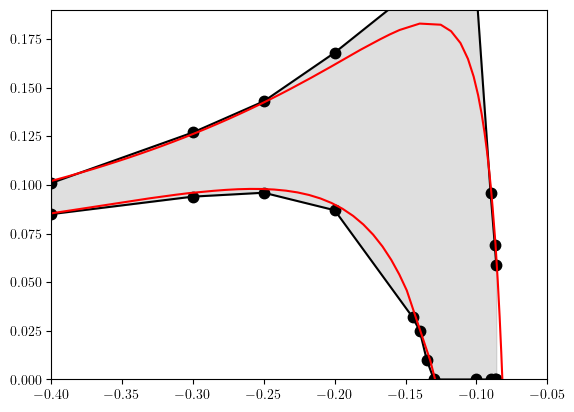

In [184]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

axs.plot(twopar_neg[:,1],twopar_neg[:,0],color='r')
axs.plot(twopar_neg2[:,1],twopar_neg2[:,0],color='r')

axs.set_ylim(0,.19)
axs.set_xlim(-.4,-.05)

In [185]:
fname_lo = '../v2_bifdat_2par/full/vdp_thal_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/vdp_thal_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

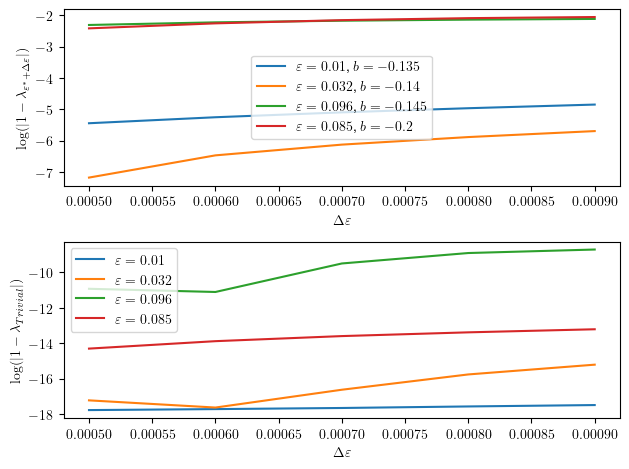

In [186]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(0.0005,0.0005+0.0001*5,.0001)
skipn = 1

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_vdp_thal_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

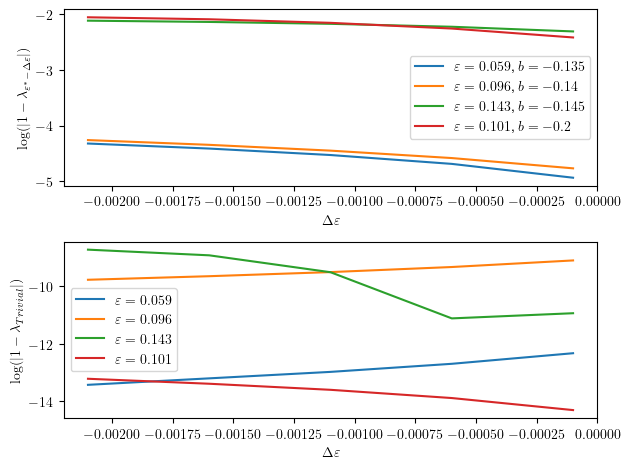

In [187]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_max_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_vdp_thal_max_{}{}.png'.format(a._n[1],a._m[1]))